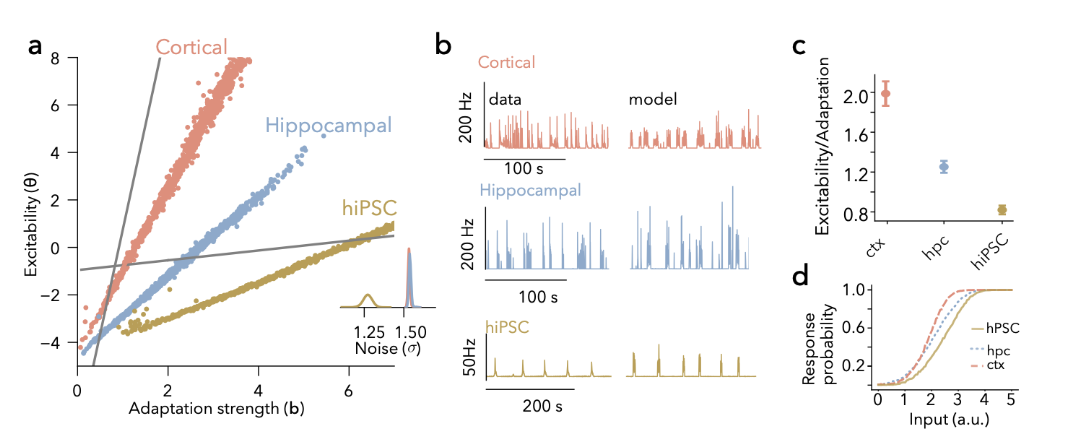

In [1]:
##Fig 4


"""
Current Figure 4 from the paper
"""


%matplotlib inline

#%% 
from src.dynamics_Model2 import StochSim_o
from src.helpers import spike_burst_det
from src.helpers import reduce_params,expand_params
import matplotlib.pyplot as plt
from os import listdir 
from os.path import isfile, join
import numpy as np
from scipy.io import loadmat as loadmat
na =np.array
import torch
from src.sbi_helpers import simulatorDurs as simulator
from src.vis.plot import pairplot#, probs2contours
# from src.data_proc.data_utils import read_burst_stat
from sbi.inference import simulate_for_sbi
import seaborn as sns
from sbi import utils as utils
from sbi.simulators.simutils import simulate_in_batches
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi

from functools import partial
from src.sbi_helpers import state_checker
from src.sbi_helpers import simulatorDurs as simulator
simulator2=partial(simulator,keys=['b','theta','tau_w','sigma'])
import pandas as pd
map_vales= []
from scipy.stats import gaussian_kde as kde
from scipy.optimize import minimize
from src.vis.styling_func import to_inches
from src.dynamics_Model2 import get_slope
from src.helpers import fit_nd_gaussian

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


from src.vis.bifurcations import plot_bifurcations


from src.vis.styling_func import colours as colours

from src.data_proc.ephys_utils import read_ctx_hpc_data


from src.vis.extra_plots import shaded_error

posteriors_nsf_snp = np.load('../../results/durations/posterior_snp_nsf_3par_n100000_14.03.22.npy',allow_pickle=True) # new fit with fixed number of bursts


posterior = posteriors_nsf_snp.item()


In [2]:
# Charleseworth
# Load the data

# summ_ch = pd.read_csv('../../data/CtxHipp/ctx_hipp_summary_full_single.csv') 
summ_ch = pd.read_csv('../../data/CtxHipp/ctx_hipp_summary_full_single_v2024.csv') 
summ_ch['name'] = 'Charleseworth'
summ_ch.rename({'region':'culture_type'},axis=1,inplace=True)
summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'


# Hyv
# summ_hy = pd.read_csv('../../data/iPSCcsCTX/summaries_2/ctx_hipp_summary_full_out_single.csv') # Hy
summ_hy = pd.read_csv('../../data/iPSCcsCTX/summaries_2/hyv_hPSC_summary_full_out_single.csv') # Hy

summ_hy['name'] = 'Hyv'
summ_hy['culture_type'][summ_hy['culture_type']=="Rat"] ='ctx'


all_table = pd.concat([summ_ch, summ_hy], ignore_index=True, axis=0)
# avg_table = all_table[(all_table['DIV']==21)].groupby(['name','culture_type']).mean().reset_index()

selected_summaries =['ibi','cvibi','dur'] 
# n_samples = 100
# x_os = na(avg_table[selected_summaries])

<ipython-input-2-c5cbf09c1892>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
<ipython-input-2-c5cbf09c1892>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'
<ipython-input-2-c5cbf09c1892>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_hy['culture_type'][summ_hy['culture_type']=="Rat"] ='ctx'


# Example fits

In [3]:

def plot_samples(ax1,colors):
    inds = [0,1,2]#[0,1,4]
    # axin1 = ax1.inset_axes([0.8, 0.05, 0.05, 0.3])
    # axin2 = ax1.inset_axes([0.8, 0.4, 0.05, 0.3])
    # insets = [axin1,axin2]
    # grad_colors = na([[230,60,181],
    #                  [56,98,154],
    #                  [231,131,66]
    #                  ])/255
    
    
    grad_colors = na([[0,0,0],
                     [0,0,0],
                     [0,0,0]
                     ])/255
    
    cmaps = ['Reds','Blues','copper_r']
    for i,ind in enumerate(inds):
        sampl = posterior.sample((1000,), x=x_os[ind]).numpy()
        # mask = (sampl[:,4]>50)*(sampl[:,4]<100)
        # sampl = sampl[:,:]
        # cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap',
                                                 # np.vstack([grad_colors[i],colors[i]]),
                                                 # gamma=1,
                                                # N=20)
        
        cax =ax1.scatter(sampl[:,0],-sampl[:,1],s=2.5,color=colors[i])
                 # c=sampl[:,2]/1000,#np.exp(sampl[:,2])/1000,
# )#,norm=matplotlib.colors.LogNorm()) cmap =cmap,
        

        # ax1.plot(sampl[:200,0][:],-sampl[:200,1][:],'.',
                # alpha=.5,color=colors[i])
        
        ibi = x_os[ind][0]
        dur = x_os[ind][2]
        j=9
        
        slope = get_slope(ibi,dur,j)
        
        bs = np.arange(1,9,0.1)
        thetas = (bs*slope)-(j/2)
        ax1.plot(bs,thetas,'--',lw=2,color=colors[i])
        # axin1 = ax1.inset_axes([0.1, 0.75, 0.45, 0.15])

        # cbar =plt.colorbar(cax,cax=insets[i],)
        # # insets[i].axis('off')
        # cbar.ax.get_yaxis().labelpad = 15
        # cbar.ax.set_ylabel('$log (\\tau_w)$', rotation=-270,labelpad=2)
        # sns.despine(ax=insets[i])

        value, sigma, min_val = fit_nd_gaussian(sampl)


        
        ax1.plot(value[0],-value[1],'o',
                markersize=6.1,mec='k',
                alpha=1.,
                # label=names[ind]+'_'+types[ind],
                color=colors[i])
        

        # sns.kdeplot(np.exp(sampl[:,2])/1000,ax=ax2,color=colors[i])
        # ax2.hist(sampl[:,2]/1000,100,color=colors[i])
        # ax2.hist(np.exp(sampl[:,2])/1000,color=colors[ind])
        # sns.kdeplot(sampl[:,4]/1000,ax=ax3,color=colors[ind])
        # ax3.hist(sampl[:,4]/1000,color=colors[ind])
        # sns.kdeplot(sampl[:,3],ax=ax4,color=colors[i])
        # ax4.hist(sampl[:,3],50,color=colors[i],density=1)

    return None 

In [4]:
# Select the data

data_ctx =summ_ch[(summ_ch['culture_type']=='ctx')* (summ_ch['name']=='Charleseworth') * (summ_ch['DIV']==24)][['ibi','cvibi','dur']]
data_hpc =summ_ch[(summ_ch['culture_type']=='hipp')* (summ_ch['name']=='Charleseworth') * (summ_ch['DIV']==24)][['ibi','cvibi','dur']]
# data_psc = all_table[(all_table['DIV']==24)*all_table['culture_type']=='hPSC'][['ibi','cvibi','dur']]
data_psc = all_table[(all_table['DIV']==38)*all_table['culture_type']=='hPSC'][['ibi','cvibi','dur']]



In [5]:
n=7

x_os = np.vstack([na(data_ctx)[7],#7
na(data_hpc)[1],#4
na(data_psc)[3]])

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

(1.1, 1.7)

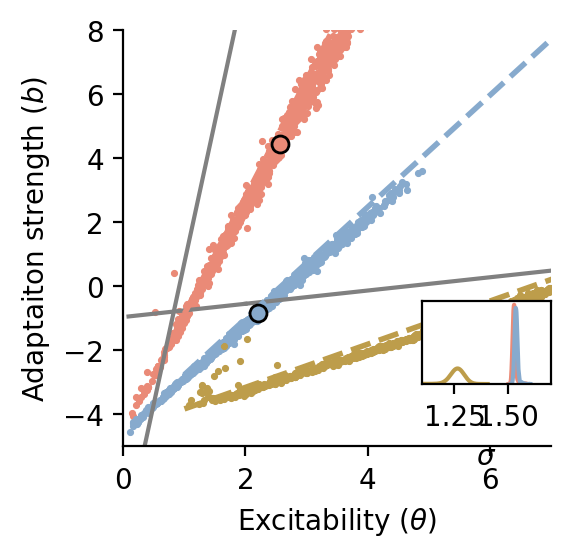

In [6]:
from src.vis.styling_func import color_violin
fig = plt.figure(figsize= (to_inches(7),to_inches(7)),dpi=200)#layout="constrained",
ax_dict = fig.subplot_mosaic(
    [
        ["scatter","scatter",],
        ["scatter","scatter",],
        ["scatter","scatter",],
        ["scatter","scatter",],
        ["scatter","scatter",],
        ["scatter","scatter",],
    ],
    gridspec_kw ={'wspace':.5,'hspace':1, }#
)

names = ['ctx','hpc','iPSC']

colors = sns.color_palette('colorblind',n_colors=4)
axin1 = ax_dict['scatter'].inset_axes([0.7, 0.15, 0.3, 0.2])
plot_bifurcations(inverse=1,ax=ax_dict['scatter'],color=[0.5,0.5,0.5])
plot_samples(ax_dict['scatter'],list(colours.values()))
ax_dict['scatter'].set_ylim([-5,8])
ax_dict['scatter'].set_xlim([0,7])

    # plt.ylim(-5,8)
    # plt.xlim(0,7)

# ax_dict['scatter'].set_xlim([0,2.5])
# ax_dict['scatter'].set_ylim([-5,1])
ax_dict['scatter'].set_xlabel('Excitability ($\\theta$)')
ax_dict['scatter'].set_ylabel('Adaptaiton strength ($b$)')

sns.despine(ax=ax_dict['scatter'])

names = ['ctx','hpc','iPSC']
for i in range(3):
    sampl = posterior.sample((1000,), x=x_os[i]).numpy()
    sns.kdeplot(sampl[:,3],ax=axin1,color=colours[names[i]])


axin1.set_yticks([])
axin1.set_ylabel('')
axin1.set_xlabel('$\\sigma$')
axin1.set_xlim([1.1,1.7])
# plt.savefig('../../results/figs/paper_figs/posteriors.pdf')
# plt.savefig('../../results/BC23-figures/CTXvsHPC2.pdf',bbox_inches='tight')#,papertype='A0')

# Example trajectories

In [7]:
# Load spikes
from src.data_proc.ephys_utils import load_hyv
spikes_filt = load_hyv()
spks= read_ctx_hpc_data()


In [8]:
spks_ctx = spks[(spks['DIV']==24)*(spks['region']==b'ctx')]
spks_hpc = spks[(spks['DIV']==24)*(spks['region']==b'hpc')]

sts = na(spikes_filt['st'])
gids = na(spikes_filt['gid'])
st = sts[2]
gid = gids[2]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

median 1.5952423
112788.24511572985
62
----Bursts-----
4.358770491803279 0.6265499146357024 2.9341935483870967


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

median 0.43725234
164654.13506031502
41
----Bursts-----
8.906749999999999 0.6798100979808855 2.13890243902439


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

median 0.10993543
111396.32418367025
9
----Bursts-----
47.976875 0.1287405041953678 3.665555555555555


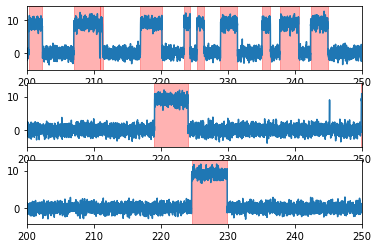

In [9]:

burst_detection_params={'maxISIstart':10.,
                    'maxISIb':10.,
                    'minBdur':17.,
                    'minIBI':20.,
                    'minSburst':17.,
                    'scale':10.
                    }

res = []
example_sum= [] 
example_par = []
np.random.seed(123456789)
for i,x in enumerate(x_os):#[150,800,1600]):
    # sampl = samples[i,:].copy()
    sampl = posterior.sample((1,),x).numpy()

    plt.subplot(3,1,i+1)
    # sampl = samples[sorted_ind[ind],:].numpy()
    # sampl = posterior.sample((1,), x=x_os[i]).numpy()[0]
    params = expand_params(sampl.tolist()[0],T=600000,torch_=False,keys=['b','theta','tau_w','sigma'])
    example_par.append(sampl)
    params['x0']=0
    
    t_dyn,x_dyn,w_dyn = StochSim_o(params,torch=0)
    print('median',np.median(x_dyn))
    cut = int(len(t_dyn)/4)
    print(params['tau_w'])
    dt= np.diff(t_dyn[cut::100])[0] 
    # x_transform = 10/(1+np.exp(-1*x_dyn[cut::100]+9))

    # bursts= na(spike_burst_det(x_dyn,dt,burst_detection_params))
    # bursts = detect_derivat(x_dyn[cut:],dt)
    bursts= na(spike_burst_det(x_dyn[cut::100],dt,burst_detection_params))
    bursts = bursts+0.05*cut
    res.append([t_dyn[cut:],x_dyn[cut:],w_dyn[cut:]])
    print(len(bursts))
    if len(bursts)>2:
        durs = np.diff(bursts)/1000
        ibis =(bursts[1:,0]-bursts[:-1,1])/1000
        mibi = np.mean(ibis)
        mdur = np.mean(durs)
        cv_ibis = np.std(ibis)/mibi
        cv_dur = np.std(durs)/mdur
        print('----Bursts-----')
        print(mibi,cv_ibis,mdur)
        example_sum.append([mibi,cv_ibis,mdur])
        # example_par.append(sampl)
        for b_ in bursts:
            plt.axvspan(b_[0]/1000,b_[1]/1000,alpha=0.3,color='r')
    plt.plot(t_dyn[::200]/1000,x_dyn[::200])
    # x_transform = 10/(1+np.exp(-1*x_dyn[::200]+4.5))
    # plt.plot(t_dyn[::200]/1000,x_transform-i*15)

        # plt.plot(b_[0]/1000,-i*15,'xk')
        # plt.plot(b_[1]/1000,-(i+1)*15,'xr')
    plt.xlim(200,250)
#     

In [10]:
from sklearn import linear_model
def get_poisson_coef(sc,x_dyn):
    """ get coefficients to predict the fiting rate """
    clf = linear_model.PoissonRegressor(fit_intercept=False)
    X= x_dyn
    X =X[X>4.5]
    y= sc
    y = y[y>50]
    lent = min([len(X),len(y)])
    clf.fit(X[:lent].reshape((lent,1)), y[:lent])
    return clf.coef_

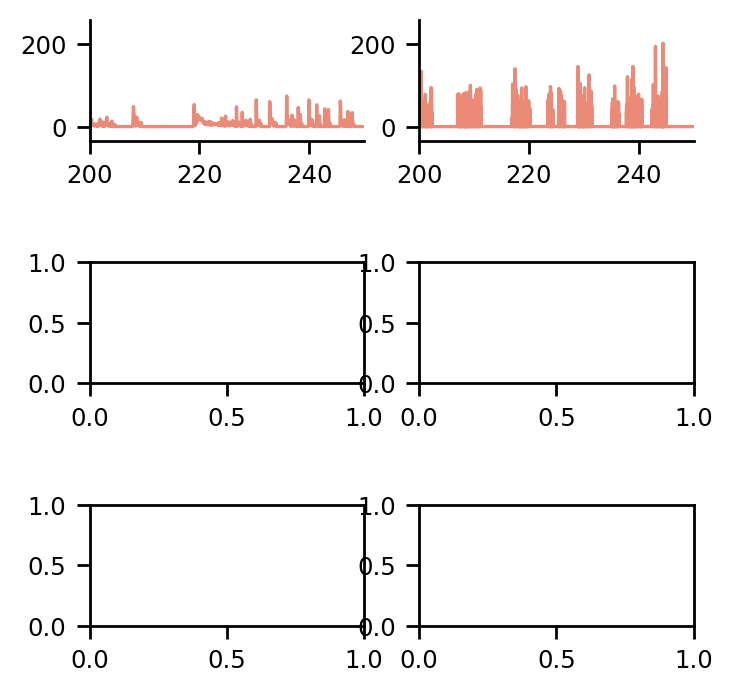

In [310]:
# Plot the activity


def generate_axes(fig):
    gridspec = fig.add_gridspec(nrows=3, ncols=12,hspace=1,wspace=1)
    axes = {}
    axes['a'] = fig.add_subplot(gridspec[0:1, 0:3])
    axes['b'] = fig.add_subplot(gridspec[1:2, 0:3])
    axes['a1'] = fig.add_subplot(gridspec[0:1, 3:6])
    axes['c'] = fig.add_subplot(gridspec[2:3, 0:3])
    axes['b1'] = fig.add_subplot(gridspec[1:2, 3:6])
    axes['c1'] = fig.add_subplot(gridspec[2:3, 3:6])

    return axes
data = []


x_os = np.vstack([na(data_ctx)[7],
na(data_hpc)[1],#4
na(data_psc)[3]])

# sts = na(spikes_filt['st'])
# gids = na(spikes_filt['gid'])
# st = sts[2]
# gid = gids[2]

sns.set_context('paper')
n_electrodes = [len(np.unique(na(spks_ctx['gids'])[7])),len(np.unique(na(spks_hpc['gids'])[1])),len(np.unique(na(spikes_filt['gid'])[0]))]

from src.vis.styling_func import to_inches
fig = plt.figure(figsize=(to_inches(20.7), to_inches(10.2)),dpi=200)
axes =generate_axes(fig) 
data = [na(spks_ctx['spikes'])[7], # 7 
        na(spks_hpc['spikes'])[1],# 1
        na(spikes_filt['st'])[3]]#3
ax_list = ['a','b','c']
ymax = [1500,1500,500]
xmax = [450,450,650]
# xmax = [450,450,650]
xmax = [250,350,650]
for i in range(3):
    st = data[i]
    binsize = 0.05
    sc,bins = np.histogram(st,np.arange(0,np.max(st),binsize))
    # sc = data[i] 

    bin_size_ms = int((binsize*1000)/0.05) #(s*1000)/dt
    t = res[i][0][::bin_size_ms]
    # t = res[i][0][::2000]
    activity = res[i][1][::bin_size_ms]# binsize! 100ms
    
#     activity = res[i][1]
#     activity = activity.reshape(len(res[i][1])//bin_size_ms,bin_size_ms)
#     activity = activity.mean(1)
    
    t = res[i][0][:]
    # t = res[i][0][::2000]
    activity = res[i][1][:]# binsize! 100ms

    
    # sc_ = np.exp(k1*activity[:])
    def get_poisson_coef(sc,x_dyn):
        """ get coefficients to predict the fiting rate """
        clf = linear_model.PoissonRegressor(fit_intercept=False)
        X= x_dyn
        X =X[X>4.5]-5.4
        y= sc
        y = y[y>10]
        lent = min([len(X),len(y)])
        clf.fit(X[:lent].reshape((lent,1)), y[:lent])
        return clf.coef_#,clf.intercept_
    k1 = get_poisson_coef(sc,activity)
    # sc_,bins_ = sim_spike_count(activity[:2000000],k1,n,dt=0.05)
    # sim_spikes = np.random.poisson(np.exp(k1*activity[:]-5.4)).T
    # sim_spikes = sim_spikes.reshape(len(sim_spikes)//bin_size_ms,bin_size_ms)
    # sc_ = sim_spikes.mean(1)
    # bins_ = 
    # sc_ = sc_.reshape(len(sc_)//bin_size_ms,bin_size_ms)
    # sc_ = sc_.sum(1)
    
    # coeff = get_poisson_coef(sc,sc_)
    # ymax =# np.percentile(sc,1500)
    factor = n_electrodes[i]*0.1  # To Hz (per neuron/per channel)
    axes[ax_list[i]].plot(bins[1:],na(sc)/factor,color=list(colours.values())[i])
    axes[ax_list[i]].set_ylim(-200/factor,ymax[i]/factor)
    axes[ax_list[i]].set_xlim(200,xmax[i])
    sns.despine(ax=axes[ax_list[i]])
#     
    # axes[ax_list[i]+'1'].plot(t[::bin_size_ms]/1000,sc_[:]/factor,color='k',linewidth=.5)
    # axes[ax_list[i]+'1'].plot(bins_/1000,sc_[:],color='k',linewidth=.5)
    axes[ax_list[i]+'1'].plot(t/1000,np.exp(k1*activity-5.4)/factor,color=list(colours.values())[i])
    axes[ax_list[i]+'1'].set_xlim(200,xmax[i])
    axes[ax_list[i]+'1'].set_ylim(-200/factor,ymax[i]/factor)
    sns.despine(ax=axes[ax_list[i]+'1'])
    break
# plt.savefig('../../results/figs/paper_figs/traces.pdf')

In [232]:
k1 = get_poisson_coef(sc,activity)


In [224]:
def sim_spike_count(x,k1,n,dt=0.05):
    sim_spikes = np.random.poisson(np.exp(k1*np.ones(shape=(50,1)) * x-10)).T
    st_sim,gid_sim= np.where(sim_spikes)
    st_sim = (st_sim*dt)/1000
    binsize = 0.2
    sc_sim,bins_sim = np.histogram(st_sim,np.arange(0,np.max(st_sim),binsize))
    return sc_sim,bins_sim[1:]

In [219]:
sim_spikes = np.random.poisson(np.exp(k1*np.ones(shape=(50,1)) * x-10)).T

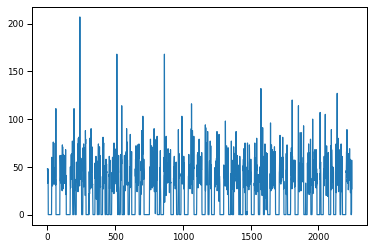

In [226]:
plt.plot(sc_)

In [47]:
st = na(spks_ctx['spikes'])[7]
gid = na(spks_ctx['gids'])[7]

In [87]:
sim_spikes = np.random.poisson(np.exp(np.random.normal(0,0.5,size=(5,1))*(activity[:1000000]).reshape(1,1000000)))


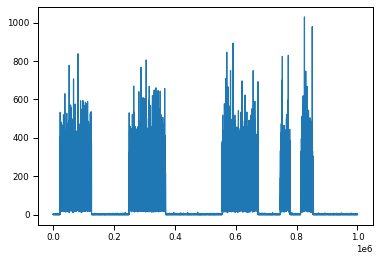

In [85]:
plt.plot(np.exp(0.5*np.ones(shape=(1,1))*(activity[:1000000]).reshape(1,1000000)).T)

In [33]:
0.5*np.ones(shape=(1,1))*activity[:1000000]

array([[ 0.05260401,  0.13982946, -0.14276218, ..., -1.02889669,
        -1.25702357, -1.15163779]])

In [123]:
# sim_spikes = np.random.poisson(np.exp(.6*np.ones(shape=(50,1))*activity[:1000000]-16)).T
sim_spikes = np.random.poisson(np.exp(np.random.normal(0,.6,size=(50,1))*activity[:1000000]-16)).T

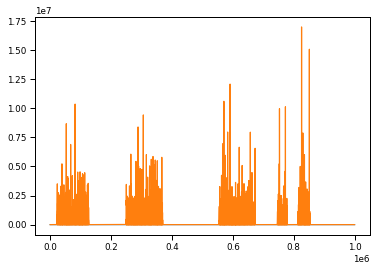

In [133]:
plt.plot(np.exp(.6*activity[:1000000]-16))
plt.plot(np.exp(1.2*activity[:1000000]))

In [126]:
binsize = 0.2
sc_sim,bins = np.histogram(st_sim,np.arange(0,np.max(st),binsize))

(0.0, 50.0)

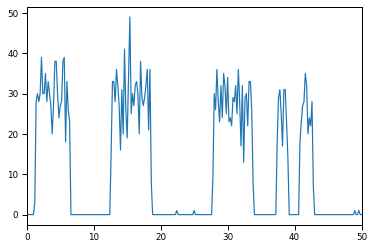

In [127]:
plt.plot(bins[1:],sc_sim)
plt.xlim(0,50)

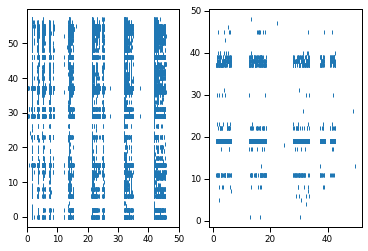

In [128]:
plt.subplot(1,2,1)
plt.plot(st,gid,'|')
plt.xlim(0,50)
plt.subplot(1,2,2)
plt.plot(st_sim,gid_sim,'|')#,ms=2,lw=.1)
# plt.xlim(0,50)

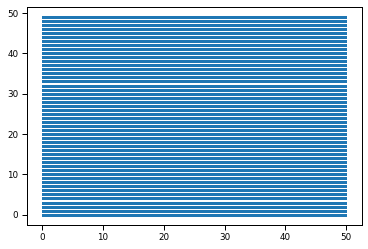

In [387]:
plt.plot(st_sim,gid_sim,'|',ms=2,lw=.1)

In [268]:
sim_spikes= np.random.poisson(sc_[:1000000])

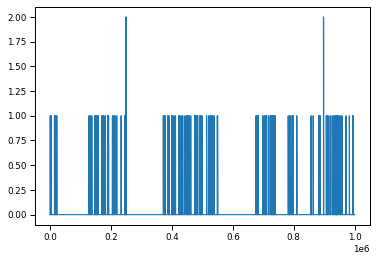

In [233]:
sim_spikes = np.random.poisson(np.exp(k1*activity[:1000000]-10)).T
activity = sim_spikes.reshape(len(sim_spikes)//bin_size_ms,bin_size_ms)
activity = activity.mean(1)
plt.plot(sim_spikes)

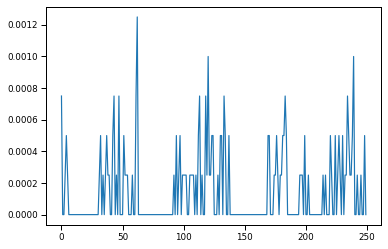

In [234]:

# plt.plot(sc_[:1000000])
plt.plot(activity)

In [113]:
activity = res[i][1][:500000]# binsize! 100ms
# sim_spikes = np.random.poisson(np.exp(np.random.normal(0,k1,size=(3,1))*activity[:]))


sim_spikes = np.exp(k1*activity[:])

In [138]:
len(sim_spikes[::bin_size_ms])

500

In [160]:
from scipy.signal import decimate as decimate
a = decimate(sim_spikes, 1000, n=1, ftype='iir', axis=-1, zero_phase=False)

In [161]:
len(a)

500

In [235]:
plt.plot(a,'-')
# plt.plot(sim_spikes[::bin_size_ms])
# plt.plot(sim_spikes,'-')

NameError: name 'a' is not defined

In [107]:
# # sim_spikes
# activity = sim_spikes.reshape(len(res[i][1])//bin_size_ms,bin_size_ms)
# # activity = activity.mean(0)
# activity = activity.mean(1)

In [108]:
gid_sim,st_sim = np.where(sim_spikes)
st_sim = (st_sim*0.05)/1000

In [109]:
sc,bins = np.histogram(st_sim,np.arange(0,np.max(st_sim),binsize))


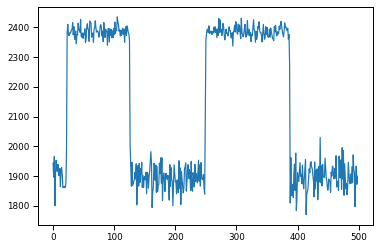

In [110]:
plt.plot(sc,)

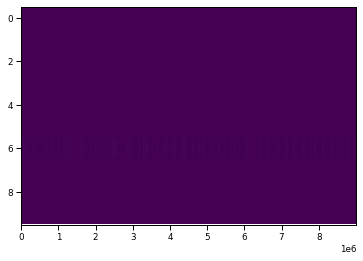

In [225]:
plt.imshow(sim_spikes,aspect='auto')

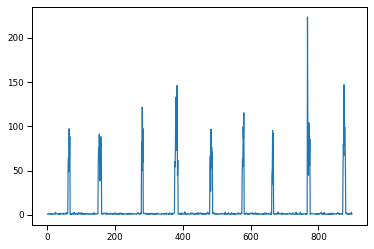

In [186]:
plt.plot(sc_[::10000])

# Plot the average Exctiability/adaptation

In [150]:
# Sample posteriores for all points of the recording data
# from src.sbi_helpers import fit_nd_gaussian
from scipy.stats import linregress

def get_all_div(data):
    samples= np.ones(shape = (len(np.unique(data['DIV'])),100,10000,4))*np.nan
    an_slopes = np.ones(shape = (len(np.unique(data['DIV'])),100))*np.nan
    tau_w_slopes =  np.zeros(shape = (len(np.unique(data['DIV'])),100))*np.nan
    
    for div_i, div in  enumerate(np.unique(data['DIV'])):
        data_ =data[data['DIV']==div]
        xos = na(data_[selected_summaries])
        for i,x_0 in enumerate(xos):
            if np.isfinite(x_0[0]):
                posterior.set_default_x(x_0)
                samples_nsf_snp= posterior.sample((10000,), x=x_0,show_progress_bars=False)
                samples_nsf_snp[:,1] = - samples_nsf_snp[:,1]
                samples[div_i,i,:,:]= samples_nsf_snp.numpy()
                an_slopes[div_i,i] = get_slope(x_0[0],x_0[2],9)
                
                # mask = (samples_nsf_snp[:,0]<1.1)*(samples_nsf_snp[:,0]>.9)
                
                slope_num, intercept, r_value, p_value, slope_err = linregress(samples_nsf_snp[:,0],np.exp(samples_nsf_snp[:,2])/1000)
                # s1,s2= samples_nsf_snp[:,0].numpy().reshape(-1,1),na(np.exp(samples_nsf_snp[:,2].numpy())/1000).reshape(-1,1).ravel()
                # print(s1)
                # s1,s2 = np.reshape(samples_nsf_snp[:,0].numpy(),(5000,1)),np.reshape(np.exp(samples_nsf_snp[:,2].numpy())/1000,(5000,1))
                # huber = HuberRegressor(fit_intercept=False,epsilon=1.,alpha=0.).fit(s1,s2)
                # plt.plot(samples[:100,0],-samples[:100,1],'.',ms=1,alpha=0.9,color = colors[i])
                # value, sigma, min_val = fit_nd_gaussian(samples_nsf_snp.numpy())
                # print(huber.coef_)
                tau_w_slopes[div_i,i]=slope_num#huber.coef_#np.exp(value[2])/1000#np.mean(np.exp(samples_nsf_snp[mask,2].numpy())/1000)
            else: 
                samples[div_i,i,:,:] = np.nan
    return samples,an_slopes,tau_w_slopes


ch_ctx_data =summ_ch[(summ_ch['culture_type']=='ctx')* (summ_ch['name']=='Charleseworth')]
samples_ctx,an_slopes_ctx,tau_w_slopes_ctx = get_all_div(ch_ctx_data)

ch_hpc_data =summ_ch[(summ_ch['culture_type']=='hipp')* (summ_ch['name']=='Charleseworth')]
samples_hpc,an_slopes_hpc,tau_w_slopes_hpc = get_all_div(ch_hpc_data)

hy_psc_data =summ_hy[(summ_hy['culture_type']=='hPSC')* (summ_hy['name']=='Hyv')]            
samples_psc,an_slopes_psc,tau_w_slopes_psc = get_all_div(hy_psc_data)



In [151]:
# Days 
div_hpc = np.unique(ch_hpc_data['DIV'])
div_hy = np.unique(hy_psc_data['DIV'])

In [152]:
div_hy[5:]
# div_hpc[3:]

array([24, 28, 31, 35, 38, 42, 45, 48, 51, 56, 59, 63])

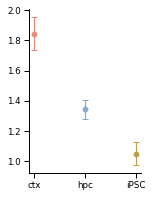

In [154]:
plt.figure(figsize=(2,3))
names = ['ctx','hpc','iPSC']
data_list_sl= []
names_list_sl =[]
masks = []
for i,data in enumerate([an_slopes_ctx[3:,:],#>14DIV
                         an_slopes_hpc[3:,:],#>14DIV
                         an_slopes_psc[5:,:] #>=24DIV
                        ]):
    data_ = np.hstack(data)
    masks.append(data_>0)
    mask = masks[i]
    data_ =data_[np.isfinite(data_)*mask]
    # data_ =data_[np.isfinite(data_)]
    data_list_sl.append(data_)
    names_list_sl.extend([names[i]]*len(data_))
    # print(len(data_))
    # plt.violinplot(data_, positions=(i,));
    plt.errorbar(i,np.mean(data_),np.std(data_)/np.sqrt(len(data_)),fmt='o',capsize=3,color=colours[names[i]])
    # plt.hist(np.hstack(data))
    # plt.plot(np.random.normal(i,0.1,size=(len(data_))),data_,'.')
    # sns.kdeplot(data_)
plt.xticks([0,1,2],names)
sns.despine()
# plt.savefig('../../results/BC23-figures/ctx_hpc_hiPSC_slopes_.pdf',bbox_inches='tight')#,papertype='A0')

In [598]:
[len(d) for d in data_list_sl]

[150, 221, 92]

# Statistics of E/A ratio

In [165]:
# from scipy.stats import ttest_ind
pvals =[]
tvals = []
for i,j in [[0,1],[1,2],[0,2]]:
    ttest = ttest_ind(data_list_sl[i],data_list_sl[j],permutations=100000, equal_var=False)
    pvals.append(ttest.pvalue)
    tvals.append(ttest.statistic)

In [166]:
print(pvals)
print(tvals)
from statsmodels.stats.multitest import multipletests
reject, p_corrected, _, _ = multipletests(pvals, method='fdr_bh')
print("Rejected hypotheses after BH-FDR correction:", reject)
print("Corrected p-values:", p_corrected)

[6.999930000699993e-05, 0.0041399586004139954, 9.99990000099999e-06]
[3.881946878837333, 2.9558541921989887, 5.892590324394007]
Rejected hypotheses after BH-FDR correction: [ True  True  True]
Corrected p-values: [1.0499895e-04 4.1399586e-03 2.9999700e-05]


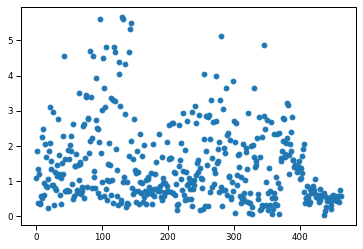

In [159]:
plt.plot(np.hstack(data_list_sl),'o')

In [193]:
0.05/9

0.005555555555555556

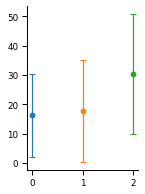

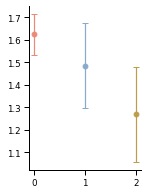

In [175]:
plt.figure(figsize=(2,3))
# names = ['ctx','ctx','ctx','hpc','hiPSC','moss','but']
names = ['ctx','hpc','hiPSC']
data_list= []
names_list = []
data_list_t = []
masks =[]
for i,data in enumerate([tau_w_slopes_ctx[3:,:],tau_w_slopes_hpc[3:,:],tau_w_slopes_psc[5:,:]]):
    data_ = np.hstack(data)
    masks.append(data_>0)
    data_[data_<0]=np.nan 

    data_ =data_[np.isfinite(data_)]
    data_list.extend(data_)
    data_list_t.append(data_)
    names_list.extend([names[i]]*len(data_))
    # print(len(data_))
    # plt.violinplot(data_, positions=(i,));
    plt.errorbar(i,np.mean(data_),np.std(data_),fmt='o',capsize=3,)#color=colours[names[i]])

sns.despine()

plt.figure(figsize=(2,3))
names = ['ctx','hpc','iPSC']
data_list_noise= []
names_list_noise =[]
data_list_t_noise = []
for i,data in enumerate([samples_ctx[3:,:,:,-1],samples_hpc[3:,:,:,-1],samples_psc[5:,:,:,-1]]):#, an_slopes_hpc[3:,:],an_slopes_psc[8:,:],an_slopes_moss]):
    data_ = np.hstack(np.mean(data,2))
    mask = masks[i]
    data_ =data_[np.isfinite(data_)*mask]

    
    data_list_noise.extend(data_)
    data_list_t_noise.append(data_)
    names_list_noise.extend([names[i]]*len(data_))
    # plt.violinplot(data_, positions=(i,));
    plt.errorbar(i,np.mean(data_),np.std(data_),fmt='o',capsize=3,color=colours[names[i]])
    # plt.hist(np.hstack(data),100)
    # plt.plot(np.random.normal(i,0.1,size=(len(data_))),data_,'.')
    # sns.kdeplot(data_)
# plt.xticks([0,1,2],names)
sns.despine()
# plt.savefig('../../results/BC23-figures/ctx_hpc_hiPSC_slopes.pdf',bbox_inches='tight')#,papertype='A0')
# plt.savefig('../../results/BC23-figures/ctx_hpc_hiPSC_slopes_.pdf',bbox_inches='tight')#,papertype='A0')

In [179]:
# from scipy.stats import ttest_ind
pvals_t =[]
tvals_t = []
for i,j in [[0,1],[1,2],[0,2]]:
    ttest = ttest_ind(data_list_t[i],data_list_t[j],permutations=100000, equal_var=False)
    pvals_t.append(ttest.pvalue)
    tvals_t.append(ttest.statistic)

In [177]:
# from scipy.stats import ttest_ind
pvals_t =[]
tvals_t = []
for i,j in [[0,1],[1,2],[0,2]]:
    ttest = ttest_ind(data_list_t_noise[i],data_list_t_noise[j],permutations=100000, equal_var=False)
    pvals_t.append(ttest.pvalue)
    tvals_t.append(ttest.statistic)

In [187]:
pvals_t[2]

9.99990000099999e-06

[Text(0, 0, 'ctx'), Text(1, 0, 'hpc'), Text(2, 0, 'hiPSC')]

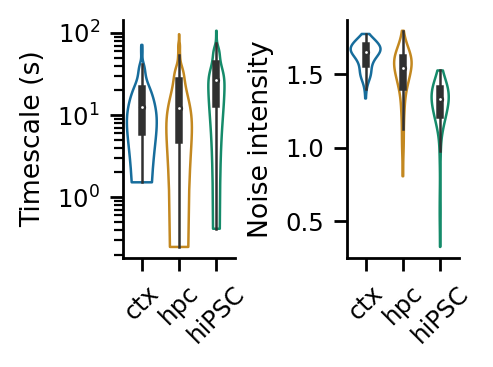

In [192]:
import matplotlib
sns.set_context('paper')
from src.vis.styling_func import to_inches
# plt.figure(figsize=(to_inches(5.5),to_inches(4.0)),dpi=200)
fig,ax = plt.subplots(1,2,figsize=(to_inches(5.5),to_inches(4.0)),dpi=200,squeeze=1,gridspec_kw= {'wspace':1})
sns.violinplot(x='type',y='Timescale (s)', data=pd.DataFrame({'Timescale (s)':data_list,'type':names_list}),
             capsize=.1,join=False,palette = colors,cut=0,ax=ax[0],linewidth=.9)
ax[0].set_yscale('log')
# sns.stripplot(x='type',y='Timescale (s)', data=pd.DataFrame({'Timescale (s)':data_list,'type':names_list}),ax=ax[0])

# plt.ylim(5,30)
for collection in ax[0].collections:
    if isinstance(collection, matplotlib.collections.PolyCollection):
        collection.set_edgecolor(collection.get_facecolor())
        collection.set_facecolor('none')

# ax[0].set_xticks([0,1,2],fontsize=8)
# ax[0].set_yticks([0,1,2],fontsize=8,rotate=45)
ax[0].set_xlabel('')
ax[0].set_xticklabels(['ctx','hpc','hiPSC'], rotation=45, ha='center')
# ax[0].set_yticks([0,10,100])
# ax[0].set_yticklabels([0,10,100])
sns.despine()
# plt.subplot(1,2,2)
sns.violinplot(x='type',y='Noise intensity',fill=False,
              data=pd.DataFrame({'Noise intensity':data_list_noise,'type':names_list_noise}),
             capsize=.1,join=False,palette = colors, cut=0,ax=ax[1],inner='box',linewidth=.9,)

for collection in ax[1].collections:
    if isinstance(collection, matplotlib.collections.PolyCollection):
        collection.set_edgecolor(collection.get_facecolor())
        collection.set_facecolor('none')


# plt.ylim(1.,2)
sns.despine()
ax[1].set_xlabel('')
ax[1].set_xticklabels(['ctx','hpc','hiPSC'], rotation=45, ha='center')
# ax[1].set_xticks([0,1,2],fontsize=8,rotation='45')
# ax[1].set_yticks([0,1,2],fontsize=8)
# ax[1].set_xlabel('')
# ax[1].set_xticklabels(['ctx','hpc','hiPSC'], rotation=45, ha='center')

# plt.subplot(1,3,3)
# sns.violinplot(x='type',y='E/A',width=1.5,
#               data=pd.DataFrame({'E/A':data_list_sl,'type':names_list_sl}),
#              capsize=.1,join=False)
# # plt.ylim(.0,2.5)
# sns.despine()


# from scipy.stats import ttest_ind
# ttest_ind(data_list_t_noise[1],data_list_t_noise[2])
# plt.savefig('../../results/figs/paper_figs/Paramters_comp.pdf')

# Perturbation

In [ ]:
# from src.helpers_model4 import expand_params,spike_burst_det
from src.helpers import expand_params,spike_burst_det
# 

# from src.helpers_model5 import expand_params,spike_burst_det


ibi_i = 0
# stimuli = np.linspace(0,4,100)
stimuli = np.linspace(0,5,100)
# stimuli = np.linspace(0,4,100)
n_ws= 50
response_curve = np.zeros(shape=(3,n_ws,len(stimuli)))#*np.nan


# noises = [0.00046, 0.00046,0.00016]#]
# tau_w_slopes = [4500,8000, 10000]

tau_w_slopes = [28000,42000,23000]
noises = [1.57,1.55,1.3]


# noises = na([0.00046, 0.00046,0.00016])*10#]
# tau_w_slopes = [4500,8000, 10000]


tau_w_slope = [26000,15000,27000]
noises = [1.5030711,1.5043137,1.3328135]


noises = [1.405,1.3099183,1.239709]
tau_w_slopes = [5600,2900 ,18600]
# slope = [2.4412319921957586, 0.4724356484913238, 0.8831019937069663]


# noises = [1.405,1.3099183,1.239709]
# tau_w_slope = [5600,900 ,18600]
# slope = [2.4412319921957586, 0.4724356484913238, 0.8831019937069663]

noises = [1.405,1.5397711,1.2649999]
tau_w_slopes = [5600,57600 ,21600]
slope = [2.4412319921957586, 1.7286181244946726,0.8142593895435863]
IBIs = slope

w_vals = []
x_vals = []
J = 9
for ibi_i, slope in enumerate(IBIs[:]):
    theta=10#3#10
    b = (theta+(J/2))/slope
    # tau_w_,b_  = get_b_tau(-theta, ibi, 1)
    tau_w_noise = (b*tau_w_slopes[ibi_i])
    params = expand_params([b,-theta,tau_w_noise,noises[ibi_i]],
                           T=900000,torch_=False,keys=['b','theta','exp_tau_w','sigma'])
    
    params['noise0'] = 0
    params['tau']=1
    params['tau_noise'] =0
    t = np.arange(0,params['T'],params['dt'])
    # params['mu']= np.zeros_like(t)
    t_dyn,x_dyn,w_dyn= StochSim_o(params,torch=0)
    x_dyn= x_dyn[5000000:]
    t_dyn=t_dyn[5000000:]
    w_dyn=w_dyn[5000000:]
    # t_dyn,x_dyn,w_dyn,noise= StochSim_o(params,torch=0)
    x_mask = (x_dyn<4.5)#*(x_dyn>-2.5)
    params['dt']=0.05
    # plt.subplot(1,3,1+ibi_i)
    # plt.plot(t_dyn[::200],x_dyn[::200])
    print('------')
    print_summary(x_dyn,t_dyn)
    print('------')
    
    # sorted_ind = np.argsort(w_dyn[x_mask][200000:])
    # sorted_w = w_dyn[x_mask][200000:][sorted_ind]
    # sorted_x = x_dyn[x_mask][200000:][sorted_ind]
    # # sorted_noise = noise[x_mask][200000:][sorted_ind]
    # # w_sel = np.percentile(sorted_w, np.linspace(0,100,10))#sorted_w[100:-100:100000]
    # x_sel = sorted_x[na(np.linspace(10,len(sorted_x)-10,100),dtype=int)]#[100:-100:100000]
    # w_sel = sorted_w[na(np.linspace(10,len(sorted_x)-10,100),dtype=int)]#[100:-100:100000]
    # noise_sel = sorted_noise[na(np.linspace(10,len(sorted_x)-10,50),dtype=int)]#[100:-100:100000]
    
    # take random values 
    indis = np.random.choice(np.random.choice(np.arange(0,np.sum(x_mask),1)),n_ws)
    
    # indis = np.random.randint(0,np.sum(x_mask),500)
    
    w_vals.append(w_dyn[x_mask][indis])
    x_vals.append(x_dyn[x_mask][[indis]])
    
    w_sel = w_dyn[x_mask][indis]
    x_sel = x_dyn[x_mask][indis]
    
    # params['T']=1000#200
    for i in range(len(w_sel)):
        params['w0'] = w_sel[i]
        params['x0'] = x_sel[i]
        # params['noise0']= np.random.normal(0,np.std(noise))#noise_sel[i]
        # params['mu'] = np.zeros_like(t)
        # params['sigma']=0.

        for mu_i,mu in enumerate(stimuli):#np.linspace(0,10,30)):
        # colors = sns.color_palette('Blues',n_colors=len(x_sel))
            t = np.arange(0,params['T'],params['dt'])
            params['w0'] = w_sel[i]
            params['x0'] = x_sel[i]
            # params['tau']=1
            # params['mu'] = np.zeros_like(t)
            params['mu']=mu
            response= [] 
            for n in range(50):
                params['w0'] = w_sel[i]
                params['x0'] = x_sel[i]
                np.random.seed(1234567+n)
                # # # params['sigma']=0.
                # params['T']=50#200
                # params['mu']=mu
                # # params['noise0']=0#np.random.normal(0,1.)#noise_sel[i]
                # t_dyn,x_dyn,w_dyn= StochSim_o(params,torch=0)
                # params['w0'] = w_dyn[-1]#w_sel[i]
                # params['x0'] = x_dyn[-1]#x_sel[i]
                params['T']=20#200
                params['mu']=mu
                t_dyn,x_dyn,w_dyn= StochSim_o(params,torch=0)
                response.append(np.max(x_dyn[:])>4.5)#2000
            # plt.plot(t_dyn,x_dyn,color=colors[i])
        # plt.plot(t_dyn,params['mu'])
            response_curve[ibi_i,i,mu_i] = np.sum(response)/len(response)
    # plt.plot(response_curve.T)


------
----Bursts-----
3.8085999999999998 0.2416994802785494 1.4322368421052634
----Ratio-----
0.37605336399340006
------
------
----Bursts-----
6.570416666666667 0.8256235216999994 1.5173469387755103
----Ratio-----
0.2309361819431305
------


In [312]:
from src.dynamics_Model2 import StochSim_o
import matplotlib.pyplot as plt
# import numpy as np
# na = np.array
from src.num_responses import get_reponse_curve

from src.helpers import expand_params,spike_burst_det

burst_detection_params={'maxISIstart':10.,
                    'maxISIb':10.,
                    'minBdur':17.,
                    'minIBI':20.,
                    'minSburst':17.,
                    'scale':10.
                    }
def print_summary(x_dyn,t_dyn):
    cut = 5000000
    dt= np.diff(t_dyn[cut::100])[0]    
    bursts= na(spike_burst_det(x_dyn[cut::100],dt,burst_detection_params))

    # bursts = bursts+0.05*cut

    # res.append([t_dyn[cut:],x_dyn[cut:],w_dyn[cut:]])
    # print(len(bursts))
    if len(bursts)>2:
        durs = np.diff(bursts)/1000
        ibis =(bursts[1:,0]-bursts[:-1,1])/1000
        mibi = np.mean(ibis)
        mdur = np.mean(durs)
        cv_ibis = np.std(ibis)/mibi
        print('----Bursts-----')
        print(mibi,cv_ibis,mdur)

        print('----Ratio-----')
        print(mdur/mibi)
    else:
        print('No bursts')

    return None


In [326]:
from src.sbi_helpers import fit_nd_gaussian

# 

In [328]:
map_value

(4,)

In [348]:
# responses

n_ws =400
n_rep = 100
responses = np.zeros(shape= (20,len(x_os),n_ws,100))
wss = []
for i,x in enumerate(x_os):#[150,800,1600]):
    # for n in range(20):
        # sampl = samples[i,:].copy()
    sampl = posterior.sample((10000,),x).numpy()
    map_value, sigma, min_val = fit_nd_gaussian(sampl)
    for n,s in enumerate([map_value]):
        stimuli = np.linspace(0, 6, 100)
        params = expand_params(s,T=900000,torch_=False,keys=['b','theta','tau_w','sigma'])
        # params = expand_params([b,-theta,tau_w_noise,noises[ibi_i]],
        #                            T=900000,
        #                            torch_=False,keys=['b','theta','exp_tau_w','sigma'])
        rc,w_sel = get_reponse_curve(params,n_ws=n_ws,n_rep=n_rep,stimuli=stimuli)
        wss.append(w_sel)
        responses[n,i,:,:] =rc

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

---Burst Summary---
----Bursts-----
4.838125 0.5319832425036264 3.0750000000000006
----Ratio-----
0.6355767988631962
------


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

---Burst Summary---
----Bursts-----
11.901538461538461 0.5805889623052658 2.733571428571428
----Ratio-----
0.22968219087014327
------


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

---Burst Summary---
----Bursts-----
50.712500000000006 0.32945526250924323 3.8833333333333333
----Ratio-----
0.07657546627228658
------


In [354]:
get_slope(x_os[:,0],x_os[:,2],9)

array([3.64917916, 1.74330282, 0.67279827])

In [353]:
x_os

array([[ 4.39402459,  0.65450173,  2.99665854],
       [ 7.56941053,  0.73036206,  1.81842708],
       [49.7194    ,  0.23840418,  4.01709091]])

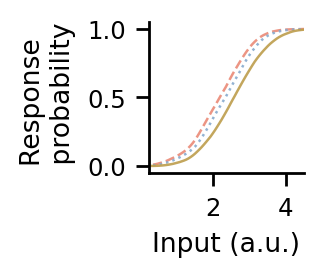

In [368]:
culture_type =['ctx','hpc','iPSC']
line_styles= ['--',':','-']
plt.figure(figsize=(1.,1.),dpi=200)
for i in range(3):
    avgresp =responses[0,i,:,:].mean(0)
    error = np.std(avgresp,0)
    mean_x = avgresp.mean(0)
    # shaded_error(stimuli,avgresp.mean(0),errors,color=colours[culture_type[i]]);
    # plt.plot(stimuli, mean_x, '-',color=colours[culture_type[i]],linestyle=line_styles[i],linewidth=1)
    # plt.fill_between(stimuli, mean_x-error, mean_x+error,color=colours[culture_type[i]],alpha=0.2)
    plt.plot(stimuli,avgresp.T,color=colours[culture_type[i]],alpha=0.9,lw=.9,ls = line_styles[i]);
plt.xlabel('Input (a.u.)')
plt.ylabel('Response \n probability')
sns.despine()
plt.xlim(0.25,4.5)
# plt.savefig(')
plt.savefig('../../results/figs/paper_figs/Fig4_responses_MAP.pdf',bbox_inches='tight',)#)

In [346]:
# responses

n_ws =100
n_rep = 20
responses2 = np.zeros(shape= (50,len(x_os),n_ws,50))
wss = []
for i,x in enumerate(x_os):#[150,800,1600]):
    # for n in range(20):
        # sampl = samples[i,:].copy()
    sampl = posterior.sample((50,),x).numpy()
    # map_value, sigma, min_val = fit_nd_gaussian(sampl)
    for n,s in enumerate(sampl):
        stimuli = np.linspace(0, 6, 50)
        params = expand_params(s,T=900000,torch_=False,keys=['b','theta','tau_w','sigma'])
        # params = expand_params([b,-theta,tau_w_noise,noises[ibi_i]],
        #                            T=900000,
        #                            torch_=False,keys=['b','theta','exp_tau_w','sigma'])
        rc,w_sel = get_reponse_curve(params,n_ws=n_ws,n_rep=n_rep,stimuli=stimuli)
        wss.append(w_sel)
        responses2[n,i,:,:] =rc

Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

---Burst Summary---
----Bursts-----
4.373518518518519 0.6462630743029846 2.763035714285714
----Ratio-----
0.6317649513969961
------
---Burst Summary---
----Bursts-----
4.250925925925926 0.5558739874600714 2.8200000000000003
----Ratio-----
0.6633848834676542
------
---Burst Summary---
----Bursts-----
5.649761904761904 0.5454949047095085 3.3793181818181823
----Ratio-----
0.5981346185526726
------
---Burst Summary---
----Bursts-----
4.085892857142857 0.7221634405248707 2.73551724137931
----Ratio-----
0.6695029304542692
------
---Burst Summary---
----Bursts-----
4.667 0.5861033254028275 2.869230769230769
----Ratio-----
0.6147912511743666
------
---Burst Summary---
----Bursts-----
5.677142857142857 0.5503300028068435 3.353181818181818
----Ratio-----
0.5906460172942307
------
---Burst Summary---
----Bursts-----
4.810208333333334 0.5480230975532483 3.1018
----Ratio-----
0.6448369353371735
------
---Burst Summary---
----Bursts-----
4.117142857142857 0.6252080156859902 2.705344827586207
----Rat

IndexError: index 20 is out of bounds for axis 0 with size 20

In [222]:
def get_states_fractions(samples,divs):
    state_fraction = np.ones(shape=(divs,100,3))*np.nan
    state = np.ones(shape=(divs,100,1))*np.nan
    print(state_fraction.shape)
    print(state.shape)
    for div_i in range(divs):#div
        for n in range(100):#culture
            sampl = samples[div_i,n,:,:]
            h_sample,bis_sample,exc_sample = get_states(sampl)
            h_fraction=len(h_sample)/10000
            bis_fraction =len(bis_sample)/10000
            exc_fraction =len(exc_sample)/10000
            state_fraction[div_i,n,:]=h_fraction,bis_fraction,exc_fraction

            if np.isfinite(samples[div_i,n,0,0]):
                s = np.argmax([h_fraction,bis_fraction,exc_fraction])
                state[div_i,n,:]=s
    return state_fraction,state

{'ctx': array([0.91764706, 0.54117647, 0.46666667]),
 'hpc': array([0.52941176, 0.66666667, 0.80392157]),
 'iPSC': array([0.74117647, 0.61568627, 0.29411765]),
 'osc': array([0.8745098 , 0.75686275, 0.91764706]),
 'exc': array([0.56470588, 0.75294118, 0.67843137]),
 'bis': array([0.6627451, 0.6627451, 0.6627451])}

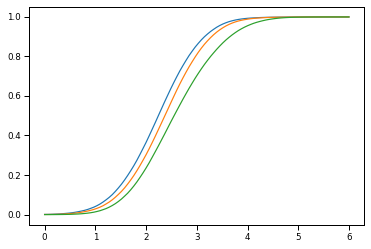

In [191]:
plt.plot(stimuli,responses[:,:,:,:].mean(0).mean(1).T);

# Figure 5

<ipython-input-595-680c676c47f7>:21: RuntimeWarning: Mean of empty slice
  shaded_error(div_hy,np.nanmean(an_slopes_psc,1),
<ipython-input-595-680c676c47f7>:24: RuntimeWarning: Mean of empty slice
  plt.plot(div_hy,np.nanmean(an_slopes_psc,1),'o',color=colours['iPSC'])


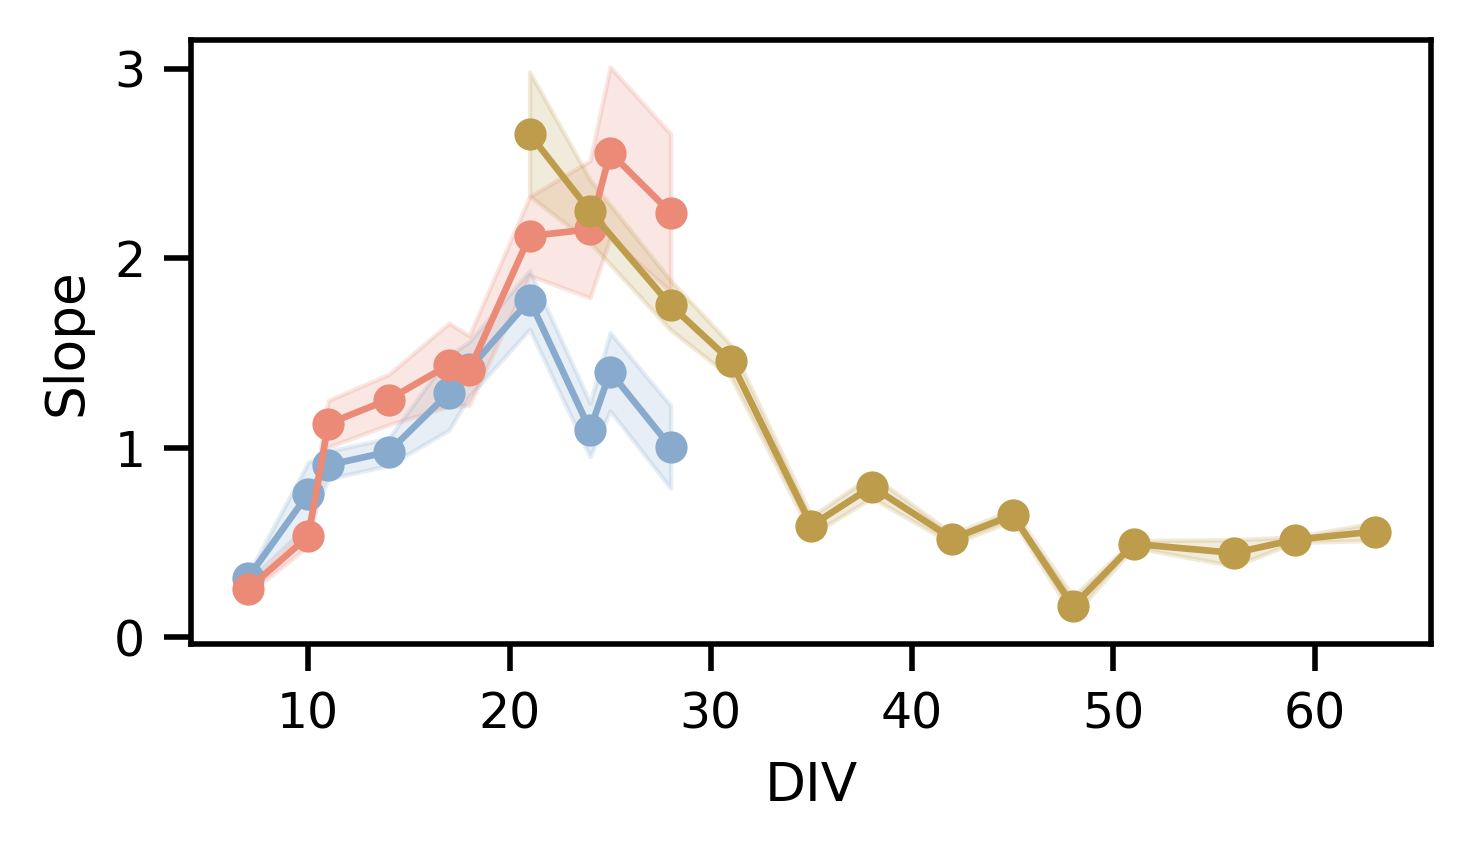

In [595]:

plt.figure(figsize=(4,2),dpi=400)#(to_inches(3.2),to_inches(1.8))
div_hpc = np.unique(ch_hpc_data['DIV'])
# plt.errorbar(div_hpc,np.nanmean(an_slopes_hpc,1),np.nanstd(an_slopes_hpc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_hpc),1)))
# /np.sqrt(np.sum(np.isfinite(an_slopes_hpc),1))
shaded_error(div_hpc,np.nanmean(an_slopes_hpc,1),
             np.nanstd(an_slopes_hpc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_hpc),1)),
             color=colours['hpc'])

plt.plot(div_hpc,np.nanmean(an_slopes_hpc,1),'o',color=colours['hpc'])

# /np.sqrt(np.sum(np.isfinite(an_slopes_ctx),1))
shaded_error(div_hpc,np.nanmean(an_slopes_ctx,1),
             np.nanstd(an_slopes_ctx,1)/np.sqrt(np.sum(np.isfinite(an_slopes_ctx),1)),
             color=colours['ctx'])
plt.plot(div_hpc,np.nanmean(an_slopes_ctx,1),'o',color=colours['ctx'])


div_hy = np.unique(hy_psc_data['DIV'])
# /np.sqrt(np.sum(np.isfinite(an_slopes_psc),1))
shaded_error(div_hy,np.nanmean(an_slopes_psc,1),
             np.nanstd(an_slopes_psc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_psc),1)),
             color=colours['iPSC'])
plt.plot(div_hy,np.nanmean(an_slopes_psc,1),'o',color=colours['iPSC'])

# plt.errorbar(div_hpc,np.nanmean(an_slopes_hpc,1),
#              np.nanstd(an_slopes_hpc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_hpc),1)),fmt='o-',capsize=1,
#              color=colours['hpc'])
# plt.errorbar(div_hpc,np.nanmean(an_slopes_ctx,1),
#              np.nanstd(an_slopes_ctx,1)/np.sqrt(np.sum(np.isfinite(an_slopes_ctx),1)),fmt='o-',capsize=1,
#              color=colours['ctx'])
# plt.errorbar(div_hy,np.nanmean(an_slopes_psc,1),
#              np.nanstd(an_slopes_psc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_psc),1)),fmt='o-',capsize=1,
#              color=colours['iPSC'])


# plt.axvline(14)
plt.xlabel('DIV')
plt.ylabel('Slope')
plt.savefig('../../results/figs/paper_figs/E_A_dev.pdf')


In [ ]:
# Plot the fraction in each state

In [227]:
def line(x,a,b):
    return (a*x) +b
# Set the priors
#Clear out the samples ouside of the distribution
# saddle_samples = []
# smlp = samples[0]
def filter_exc(samples):
    exc_samples = []
    for sample in samples:
        y_1 = -line(sample[0],-0.2,0.96)#upper branch
        y_2 = -line(sample[0],-8.8,8.06)#lower branch
        if sample[0]>0.83:
            if (sample[1]<y_1) or (sample[1]>y_2):
                exc_samples.append(sample)
        else:
            if (sample[1]<y_2) or (sample[1]>y_1):
                exc_samples.append(sample)
    return na(exc_samples)

def get_states(sampl):
    saddle_samples= []
    for sample in sampl:
        y_1 = -line(sample[0],-0.2,0.96)#upper branch
        y_2 = -line(sample[0],-8.8,8.06)#lower branch
        if (sample[1]>y_2) * (sample[1]<y_1):
            saddle_samples.append(sample)

    hopf_samples = []
    for sample in sampl:
        y_1 = -line(sample[0],-0.2,0.96)#upper branch
        y_2 = -line(sample[0],-8.8,8.06)#lower branch
        if (sample[1]>y_1) * (sample[1]<y_2):
            hopf_samples.append(sample)
    exc_samples =  filter_exc(sampl)
    return hopf_samples,saddle_samples,exc_samples

# samples= posterior.sample((500,), x=x_os[0]).numpy()[:,:2]
# hopf_samples,saddle_samples,exc_samples = get_states(samples)
def plot_states(ax,categories,samples):
    hopf_samples,saddle_samples,exc_samples = get_states(samples)
    state_colors = ['darkgray','C0',na([207,128,122])/255]
    perc1 = len(saddle_samples)/len(samples) *100
    perc2 = len(exc_samples)/len(samples) *100
    perc3 =len(hopf_samples)/len(samples) *100
    ax.bar(categories, perc1, label='Value 1', color=state_colors[0])
    ax.bar(categories, perc2, bottom=perc1, label='Value 2', color=state_colors[1])
    ax.bar(categories, perc3, bottom=perc1+perc2, label='Value 3', color=state_colors[2])
    

In [739]:
point=[10,2,1,0]
h,s,e = get_states(na([point]))


In [740]:
h,s,e

([array([10,  2,  1,  0])], [], array([], dtype=float64))

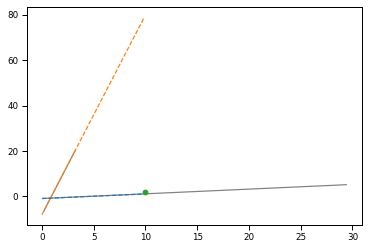

In [741]:
plot_bifurcations(inverse=-1)
y_1 = line(np.arange(0,10,0.1),-0.2,0.96)#upper branch
y_2 = line(np.arange(0,10,0.1),-8.8,8.06)#lower branch

plt.plot(np.arange(0,10,0.1),-y_1,'--')
plt.plot(np.arange(0,10,0.1),-y_2,'--')
plt.plot(point[0],point[1],'o')


In [558]:
def get_states_fractions(samples,divs):
    state_fraction = np.ones(shape=(divs,100,3))*np.nan
    state = np.ones(shape=(divs,100,1))*np.nan
    print(state_fraction.shape)
    print(state.shape)
    for div_i in range(divs):#div
        for n in range(100):#culture
            sampl = samples[div_i,n,:,:]
            h_sample,bis_sample,exc_sample = get_states(sampl)
            h_fraction=len(h_sample)/10000
            bis_fraction =len(bis_sample)/10000
            exc_fraction =len(exc_sample)/10000
            state_fraction[div_i,n,:]=h_fraction,bis_fraction,exc_fraction

            if np.isfinite(samples[div_i,n,0,0]):
                s = np.argmax([h_fraction,bis_fraction,exc_fraction])
                state[div_i,n,:]=s
    return state_fraction,state


state_fraction_hpc,states_hpc = get_states_fractions(samples_hpc,len(div_hpc))
state_fraction_ipsc,states_ipsc = get_states_fractions(samples_psc,len(div_hy))



(10, 100, 3)
(10, 100, 1)
(17, 100, 3)
(17, 100, 1)


In [228]:
def get_states_fractions_stack(samples,divs):
    state_fraction = np.ones(shape=(divs,3))*np.nan
    print(state_fraction.shape)
    for div_i in range(divs):#div
        # n_samples= np.sum(np.isfinite(samples_ctx[div_i,:,0,0]))
        mask = np.isfinite(samples[div_i,:,0,0])
        n_samples =np.sum(mask)
        if n_samples>0:
            sampl = np.concatenate(samples[div_i,mask,:,:],0)
            # sampl = sampl[np.isfinite(sampl[:,0]),:]

            h_sample,bis_sample,exc_sample = get_states(sampl)

            h_fraction=len(h_sample)/(n_samples*10000)
            bis_fraction =len(bis_sample)/(n_samples*10000)
            exc_fraction =len(exc_sample)/(n_samples*10000)

            state_fraction[div_i,:]=h_fraction,bis_fraction,exc_fraction
    return state_fraction


state_fraction_hpc = get_states_fractions_stack(samples_hpc,len(div_hpc))
# state_fraction_ipsc = get_states_fractions(samples_psc,len(div_hy))



NameError: name 'samples_hpc' is not defined

In [791]:
state_fraction_ipsc = get_states_fractions_stack(samples_psc,len(div_hy))
state_fraction_ctx = get_states_fractions_stack(samples_ctx,len(div_hpc))


(17, 3)
(10, 3)


In [781]:
div_i = 0
mask = np.isfinite(samples_hpc[div_i,:,0,0])
sampl =np.concatenate(samples_hpc[div_i,mask,:,:],0)

h_sample,bis_sample,exc_sample = get_states(sampl)


In [765]:
n=np.sum(mask)

In [783]:
(len(bis_sample)/(n*10000))

0.009091836734693878

In [782]:
(len(bis_sample)/(n*10000)) + (len(h_sample)/(n*10000) )+ (len(exc_sample)/(n*10000)) 

1.0

In [763]:
sampl.shape
len(bis_sample)+len(h_sample)+len(exc_sample)

10000.0

In [779]:
np.sum(state_fraction_hpc[0,:])

0.7619047619047619

In [784]:
state_fraction_hpc[0,:]

array([0.03117143, 0.0107    , 0.72003333])

In [671]:
n= np.sum(np.isfinite(samples_ctx[div_i,:,0,0]))


490000

In [759]:
len(bis_sample)/(n*10000)

0.02936734693877551

In [652]:
samples_hpc.shape

(10, 100, 10000, 4)

array([0.03117143, 0.0107    , 0.72003333])

In [824]:
state_fraction_ctx.shape

(10, 3)

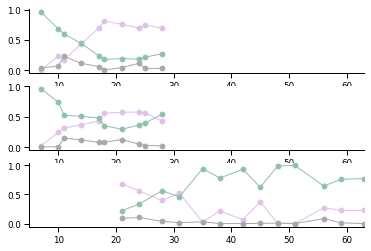

In [854]:
xaxis = [div_hpc,div_hpc,div_hy]
colors = [colours['osc'],colours['bis'],colours['exc']]
for i,state in enumerate([state_fraction_ctx,state_fraction_hpc,state_fraction_ipsc]):
    plt.subplot(3,1,i+1)
    for k in range(3):
        plt.plot(xaxis[i],state[:,k],'-o',color=colors[k],linewidth=1)
    plt.xlim(5,63)
    # plt.
    sns.despine()
    
plt.savefig('../../results/figs/paper_figs/state_dev.pdf')


In [898]:
state_fraction_ctx

array([[0.00380476, 0.03252381, 0.96367143],
       [0.23630556, 0.07666111, 0.68703333],
       [0.17193077, 0.2294    , 0.59866923],
       [0.43963438, 0.11544688, 0.44491875],
       [0.69481579, 0.06277368, 0.24241053],
       [0.81326923, 0.00602308, 0.18070769],
       [0.760925  , 0.04435313, 0.19472187],
       [0.69934211, 0.11648947, 0.18417368],
       [0.74923077, 0.03256154, 0.21820769],
       [0.69666364, 0.03069545, 0.27264545]])

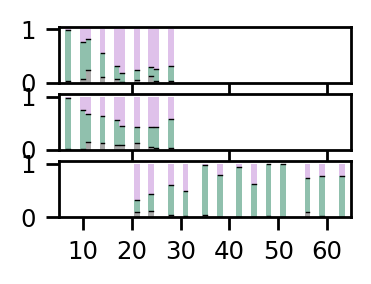

In [906]:
plt.figure(figsize=(to_inches(4.8),to_inches(3.2)),dpi=200)
xs = [div_hpc,div_hpc,div_hy]
for i,frac in enumerate([state_fraction_ctx,state_fraction_hpc,state_fraction_ipsc]):
    plt.subplot(3,1,1+i)
    x_ = xs[i]
    plt.bar(x_,frac[:,1], color=colours['bis'],width=1.2)
    plt.bar(x_,frac[:,2],bottom=frac[:,1],color=colours['exc'],width=1.2)
    plt.bar(x_,frac[:,0], 
            bottom=frac[:,1]+frac[:,2],color=colours['osc'],width=1.2)
    
    for i in range(len(x_)):
        plt.plot([x_[i] - 0.4, x_[i] + 0.4], [frac[i,1], frac[i,1]], color='black', linewidth=.5)
        plt.plot([x_[i] - 0.4, x_[i] + 0.4], [frac[i,1]+frac[i,2], frac[i,1]+frac[i,2]], color='black', linewidth=.5)

    # plt.xticks(np.arange(len(div_hpc)),div_hpc)
    # plt.xticks(np.arange(len(div_hy)),div_hy)
    # plt.xticks(np.arange(1,len(div_hy)+1,2),div_hy[::2])
    # sns.despine(left=1)
    plt.xlim(5,65)
plt.xticks([10,20,30,40,50,60])
plt.savefig('../../results/figs/paper_figs/state_dev2.pdf')


In [798]:
np.arange(1,len(div_hy),4)

array([ 1,  5,  9, 13])

In [841]:
np.diff(div_hy)

array([3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 5, 3, 4])

In [843]:
div_hpc

array([ 7, 10, 11, 14, 17, 18, 21, 24, 25, 28])

In [619]:
sampl = np.concatenate(samples_ctx[div_i,:,:,:],0)


In [620]:
sampl.shape

(1000000, 4)

In [609]:
state_fraction_ctx,states_ctx = get_states_fractions(samples_ctx,len(div_hpc))


(10, 100, 3)
(10, 100, 1)


In [611]:
state_fraction_ctx.shape

(10, 100, 3)

(1000000, 4)

In [529]:

state_fraction_hpc,states_hpc = get_states(samples_hpc,len(div_hpc))
# state_fraction_ipsc,states_ipsc = get_states(samples_psc,len(div_hy))



TypeError: get_states() missing 1 required positional argument: 'divs'

In [272]:
state_fraction[0,:,0]

array([0.    , 0.9876, 0.9252, 0.    , 0.    , 0.6166, 0.3109, 0.    ,
       0.6801, 0.8601, 0.8556, 0.    , 0.8   , 0.9435, 0.806 , 0.8397,
       0.    , 0.4751, 0.6281, 0.7519, 0.6504, 0.    , 0.    , 0.6824,
       0.    , 0.9245, 0.    , 0.    , 0.5253, 0.7911, 0.9567, 0.8341,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    ])

<Axes: >

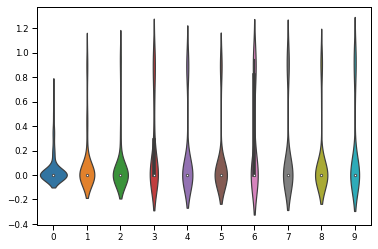

In [288]:
# sns.violinplot(state_fraction[:,:,0].T)
# sns.violinplot(state_fraction[:,:,2].T)


In [356]:
state_fraction[state_fraction==0]=np.nan
state = np.argmax(state_fraction,-1)

In [ ]:
for i in range(3);
    state==i

In [374]:
osc=(state[:,:,0]==0)
bis=(state[:,:,0]==1)
exc= (state[:,:,0]==2)

In [410]:
np.sum(np.isfinite(state[:,:,0]),1).T

array([21, 18, 13, 32, 19, 13, 32, 19, 13, 22])

In [567]:

def fraction(array,val):
    total_elements = np.sum(np.isfinite(array[:,:,0]),1).T
    num_threes = np.count_nonzero(array == val,1)
    print(num_threes.shape)
    fraction = num_threes[:,0] / total_elements
    return fraction

(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(17, 1)
(17, 1)
(17, 1)
(17, 1)
(17, 1)
(17, 1)


<ipython-input-567-1831d242a6f1>:5: RuntimeWarning: invalid value encountered in divide
  fraction = num_threes[:,0] / total_elements


AttributeError: Text.set() got an unexpected keyword argument 'rotate'

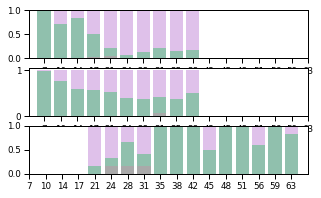

In [596]:
plt.figure(figsize=(5,3))
plt.subplot(3,1,1)
plt.bar(np.arange(len(div_hpc)),fraction(state,1), color=colours['bis'])
plt.bar(np.arange(len(div_hpc)),fraction(state,2),bottom=fraction(state,1),color=colours['exc'])
plt.bar(np.arange(len(div_hpc)),fraction(state,0), bottom=fraction(state,2)+fraction(state,1),color=colours['osc'])
# plt.xticks(np.arange(len(div_hpc)),div_hpc)
plt.xticks(np.arange(len(div_hy)),div_hy)

plt.subplot(3,1,2)
plt.bar(np.arange(len(div_hpc)),fraction(states_hpc,1), color=colours['bis'])
plt.bar(np.arange(len(div_hpc)),fraction(states_hpc,2),bottom=fraction(states_hpc,1),color=colours['exc'])
plt.bar(np.arange(len(div_hpc)),fraction(states_hpc,0), bottom=fraction(states_hpc,2)+fraction(states_hpc,1),color=colours['osc'])
# plt.xticks(np.arange(len(div_hpc)),div_hpc)
plt.xticks(np.arange(len(div_hy)),div_hy)

plt.subplot(3,1,3)
plt.bar(np.arange(len(div_hy)),fraction(states_ipsc,1), color=colours['bis'])

plt.bar(np.arange(len(div_hy)),fraction(states_ipsc,2),bottom=fraction(states_ipsc,1),color=colours['exc'])

plt.bar(np.arange(len(div_hy)),fraction(states_ipsc,0), bottom=fraction(states_ipsc,2)+fraction(states_ipsc,1),color=colours['osc'])

plt.xticks(np.arange(len(div_hy)),div_hy,rotate=45)
# plt.xlim(0,)

plt.savefig('../../results/figs/paper_figs/state_dev.pdf')

# plt.bar(div_hpc,fraction(states_hpc,0),color=colours['osc'])
# plt.bar(div_hpc,fraction(states_hpc,2), bottom=fraction(st
# ates_hpc,0),color=colours['exc'])

(10, 1)
(10, 1)
(17, 1)


<ipython-input-567-1831d242a6f1>:5: RuntimeWarning: invalid value encountered in divide
  fraction = num_threes[:,0] / total_elements


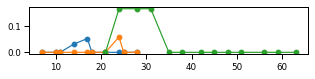

In [580]:
plt.figure(figsize=(5,3))
plt.subplot(3,1,1)
plt.plot(div_hpc,fraction(state,1),'-o')
plt.plot(div_hpc,fraction(states_hpc,1),'o-')
plt.plot(div_hy,fraction(states_ipsc,1),'o-')



# plt.subplot(3,1,3)
# plt.bar(np.arange(len(div_hy)),fraction(states_ipsc,1), color=colours['bis'])
# plt.bar(np.arange(len(div_hy)),fraction(states_ipsc,2),bottom=fraction(states_ipsc,1),color=colours['exc'])
# plt.bar(np.arange(len(div_hy)),fraction(states_ipsc,0), bottom=fraction(states_ipsc,2)+fraction(states_ipsc,1),color=colours['osc'])


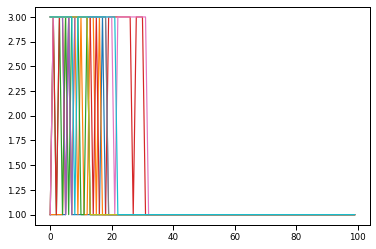

In [326]:
plt.plot(state.T)

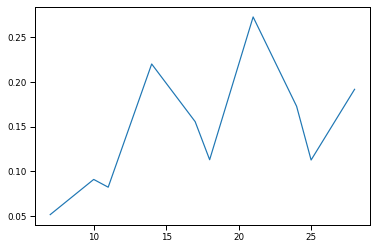

In [400]:
# n = np.sum(np.sum(state_fraction[:,:,:],-1)>0,1)
# plt.errorbar(div_hpc,np.nanmean(state_fraction[:,:,0],1),np.nanstd(state_fraction[:,:,0],1)/np.sqrt(n))

# plt.errorbar(div_hpc,np.nanmean(state_fraction[:,:,2],1),np.nanstd(state_fraction[:,:,2],1)/np.sqrt(n))

# plt.plot(div_hpc,np.nanmean(state_fraction[:,:,0],1))
# plt.plot(div_hpc,np.nanmean(state_fraction[:,:,1],1))
plt.plot(div_hpc,np.nanmean(state_fraction[:,:,2],1))
# plt.plot(state_fraction[:,0,2]/10)

<ipython-input-93-82ca2ead0b53>:4: RuntimeWarning: Mean of empty slice
  shaded_error(div_hy,np.nanmean(an_slopes_psc,1),


NameError: name 'hy_ctx_data' is not defined

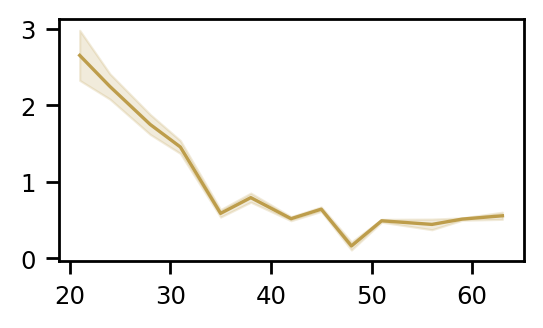

In [93]:

plt.figure(figsize=(3,1.6),dpi=200)
# sns.
div_hy = np.unique(hy_psc_data['DIV'])
shaded_error(div_hy,np.nanmean(an_slopes_psc,1),
             np.nanstd(an_slopes_psc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_psc),1)),
             color=colours['iPSC'],label='hiPSC')


div_ctx = np.unique(hy_ctx_data['DIV'])
shaded_error(div_ctx,np.nanmean(an_slopes_ctx_hy,1),
             np.nanstd(an_slopes_ctx_hy,1)/np.sqrt(np.sum(np.isfinite(an_slopes_ctx_hy),1)),
             color='darkred',label='rat ctx')
# plt.plot(div_ctx,np.nanmean(an_slopes_ctx_hy,1)/np.nanmean(an_slopes_ctx_hy,1)[1])


div_ctx = np.unique(ch_ctx_data['DIV'])
# shaded_error(div_ctx,np.nanmean(an_slopes_ctx,1),np.nanstd(an_slopes_ctx,1)/np.sqrt(np.sum(np.isfinite(an_slopes_ctx),1)),color=colours['ctx'])
# plt.plot(div_ctx,np.nanmean(an_slopes_ctx,1)/np.nanmean(an_slopes_ctx,1)[0])

sns.despine()
plt.legend(fontsize=8)
plt.ylabel('Excitability/Adaptation',fontsize=8)
plt.xlabel('Days on MEA',fontsize=8)
plt.xticks(np.arange(10,70,10),fontsize=8)
plt.yticks(fontsize=8)
# div_ctx = np.unique(ch_hpc_data['DIV'])
# shaded_error(div_ctx,np.nanmean(an_slopes_ctx,1),np.nanstd(an_slopes_ctx,1)/np.sqrt(np.sum(np.isfinite(an_slopes_ctx),1)),color=colours['ctx'])
# plt.plot(div_ctx,np.nanmean(an_slopes_hpc,1)/np.nanmean(an_slopes_hpc,1)[0])

# div_hpc = np.unique(ch_hpc_data['DIV'])
# plt.errorbar(div_hpc,np.nanmean(an_slopes_hpc,1),np.nanstd(an_slopes_hpc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_hpc),1)))
# # 

# shaded_error(div_hpc,np.nanmean(an_slopes_hpc,1),np.nanstd(an_slopes_hpc,1)/np.sqrt(np.sum(np.isfinite(an_slopes_hpc),1)),color=colours['hpc'])

# plt.savefig('../../results/figs/paper_figs/rat_vs_hiPSC.pdf')